# 02 - Advanced Analysis: Visualization, NLP, Statistical Tests, Modeling

Nội dung:
- Biểu đồ chuyên sâu (role/location/seniority)
- Khai thác văn bản `JD_Trans`
- Mô hình dự đoán lương `Est_Salary`


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import re
from collections import Counter

sns.set_theme(style="whitegrid")

CLEAN_PATH = r"D:\Truc_quan\Data_Jobs_Clean.csv"
df = pd.read_csv(CLEAN_PATH, encoding="utf-8")
print(df.shape)
df.head()


(2954, 25)


,Job_ID,Job_Title,Min_YOE,Est_Salary,JD_Trans,L1,L2,L3,L4,MinL,...,W_Term_3,W_Term_4,Data_Engineer,Data_Analyst,Data_Scientist,Business_Analyst,Business_Intelligence,Combined_role,Others,Last_Updated
0,5603,Senior Machine Learning,3,3390.0,Lang Ha Earable recruits Senior ML from 3 ++ y...,2.0,Unknown,NaN,NaN,2,...,Unknown,Unknown,1,0,1,0,0,1,0,2025-11-10
1,5602,Data Engineer,1,1270.0,HN-LLLL; Product Company recruits #data #engin...,1.0,2,NaN,NaN,1,...,Unknown,Unknown,1,0,0,0,0,0,0,2025-11-10
2,5601,Ai Research Engineer,3,2755.0,Cau Giay - HN - AI Research Engineer - 3-7year...,2.0,Unknown,NaN,NaN,2,...,Unknown,Unknown,1,0,1,0,0,1,0,2025-11-10
3,5600,Data Analyst,3,1270.0,Over 3 years of experience in data analysis.,2.0,Unknown,NaN,NaN,2,...,Unknown,Unknown,0,1,0,0,0,0,0,2025-11-10
4,5599,Data Engineer,2,1800.0,From 2 years of experience that has been worki...,1.0,Unknown,NaN,NaN,1,...,Unknown,Unknown,1,0,0,0,0,0,0,2025-11-10


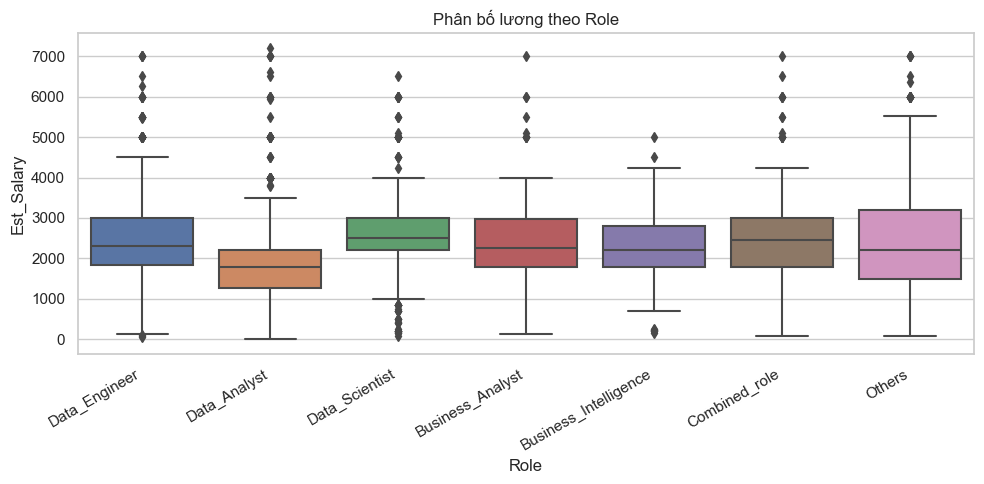

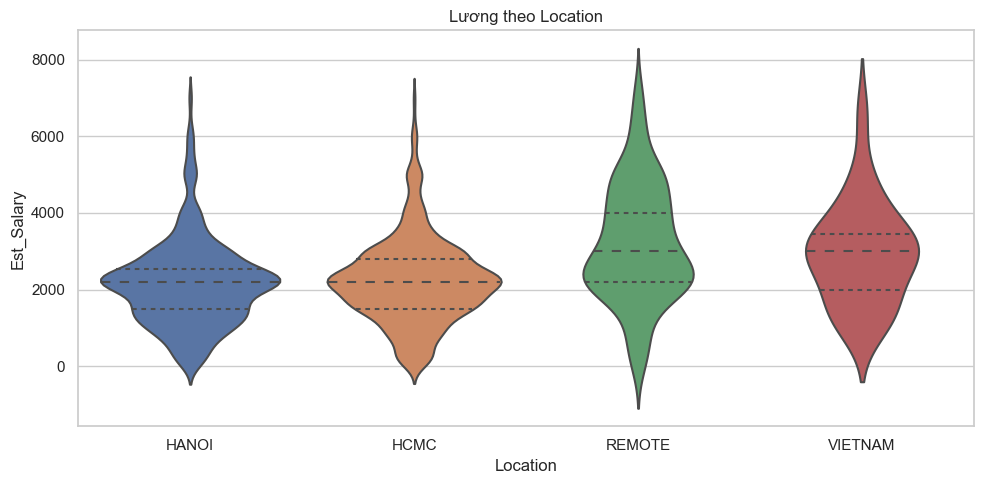

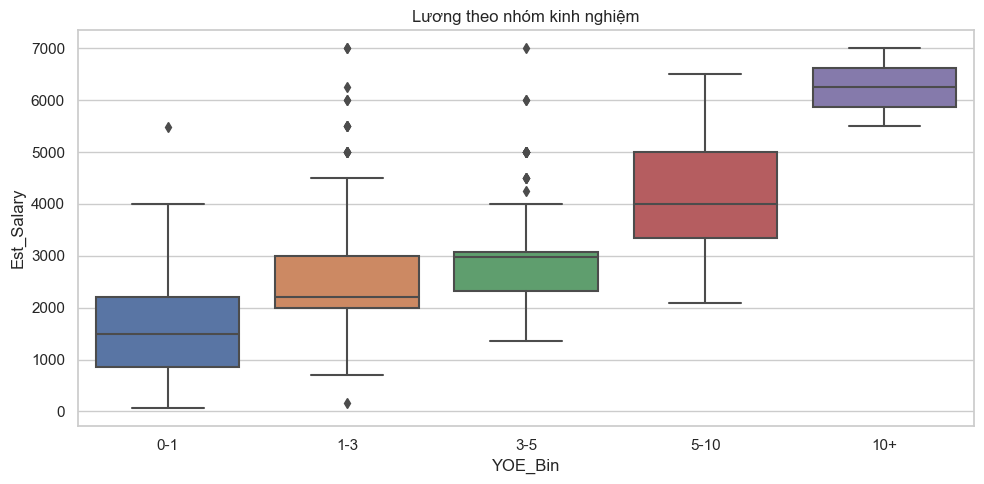

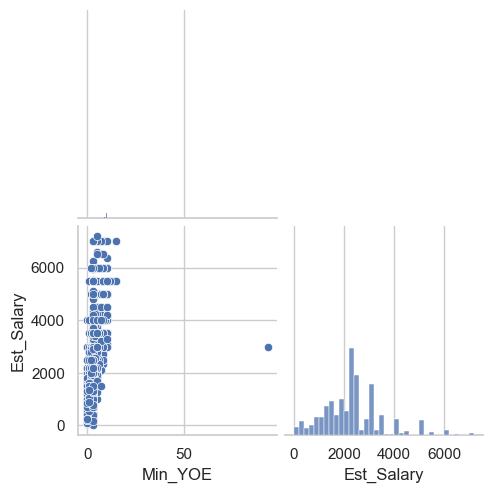

In [8]:
# Biểu đồ chuyên sâu , boxplot, violinplot, pairplot
# 1) Lương theo Role (melt role flags)
role_cols = [c for c in ["Data_Engineer","Data_Analyst","Data_Scientist","Business_Analyst","Business_Intelligence","Combined_role","Others"] if c in df.columns]
role_df = df.melt(id_vars=["Est_Salary"], value_vars=role_cols, var_name="Role", value_name="Flag").query("Flag==1")
plt.figure(figsize=(10,5))
sns.boxplot(data=role_df, x="Role", y="Est_Salary")
plt.xticks(rotation=30, ha="right") 
plt.title("Phân bố lương theo Role")
plt.tight_layout()
plt.show()

# 2) Lương theo Location và Role (facet)
plt.figure(figsize=(10,5))
sns.violinplot(data=df, x="Location", y="Est_Salary", inner="quartile")
plt.title("Lương theo Location")
plt.tight_layout()
plt.show()

# 3) Lương theo Min_YOE (bin) và Role chính
df['YOE_Bin'] = pd.cut(df['Min_YOE'], bins=[-0.1,1,3,5,10,100], labels=["0-1","1-3","3-5","5-10","10+"])
plt.figure(figsize=(10,5))
sns.boxplot(data=role_df.merge(df[['YOE_Bin']], left_index=True, right_index=True), x="YOE_Bin", y="Est_Salary")
plt.title("Lương theo nhóm kinh nghiệm")
plt.tight_layout()
plt.show()

# 4) Pairplot mở rộng
num_cols = [c for c in ["Min_YOE","Est_Salary"] if c in df.columns]
sns.pairplot(df[num_cols], corner=True)
plt.show()


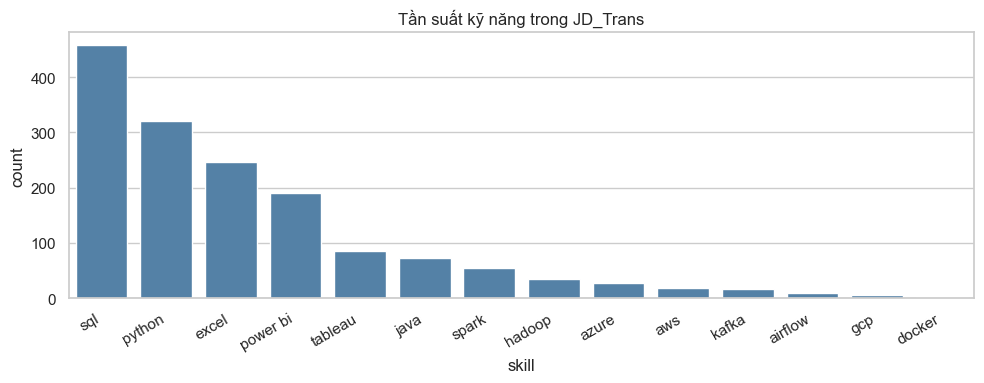

In [9]:
# Khai thác văn bản JD_Trans (NLP cơ bản) 
# Tiền xử lý văn bản , Thống kê tần xuất kỹ năng, phân tích bigram 
text_series = df.get('JD_Trans')
if text_series is not None:
    # Tiền xử lý cơ bản
    corpus = text_series.fillna('').astype(str).str.lower()
    corpus = corpus.str.replace(r"[^a-z0-9\s\+\.#]", " ", regex=True)

    # Đếm tần suất một số kỹ năng quan tâm
    skills = ['python','sql','power bi','excel','tableau','airflow','spark','aws','gcp','azure','java','docker','kafka','hadoop']
    counts = {}
    for skill in skills:
        pattern = re.compile(rf"\b{re.escape(skill)}\b")
        counts[skill] = corpus.apply(lambda x: len(pattern.findall(x))).sum()

    skills_df = pd.DataFrame(sorted(counts.items(), key=lambda x: x[1], reverse=True), columns=['skill','count'])
    plt.figure(figsize=(10,4))
    sns.barplot(data=skills_df, x='skill', y='count', color='steelblue')
    plt.xticks(rotation=30, ha='right')
    plt.title('Tần suất kỹ năng trong JD_Trans')
    plt.tight_layout()
    plt.show()

    # Bigram đơn giản
    tokens = corpus.str.split()
    bigrams = Counter(zip(*(tokens.apply(lambda x: x[i:] for i in (0,1)))))
else:
    print('Không có cột JD_Trans để khai thác văn bản.')


In [10]:
# Mô hình dự đoán Est_Salary (baseline & regularized)
# Biến đầu vào: Min_YOE + Location + Role flags
features = ['Min_YOE']
if 'Location' in df.columns:
    features.append('Location')
features += role_cols
# Chuẩn bị dữ liệu
model_df = df.dropna(subset=['Est_Salary'])
X = model_df[features]
y = model_df['Est_Salary']
# Tiền xử lý
numeric_features = ['Min_YOE']
categorical_features = []
if 'Location' in X.columns:
    categorical_features.append('Location')
# Thêm các biến vai trò
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough'
)
# xây dựng mô hình linreg và ridge
# Linear Regression
linreg = Pipeline(steps=[('prep', preprocess), ('model', LinearRegression())])
mae_cv = -cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
print(f"Linear MAE (CV=5): {mae_cv:.2f}")

# Ridge Regression
ridge = Pipeline(steps=[('prep', preprocess), ('model', Ridge(alpha=1.0))])
mae_cv_ridge = -cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
print(f"Ridge MAE (CV=5): {mae_cv_ridge:.2f}")

# Fit và đánh giá hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print("Hold-out MAE:", mean_absolute_error(y_test, y_pred))
print("Hold-out MAPE:", mean_absolute_percentage_error(y_test, y_pred))


Linear MAE (CV=5): 669.18
Ridge MAE (CV=5): 667.98
Hold-out MAE: 727.7470698738821
Hold-out MAPE: 2.1539969007390124e+16


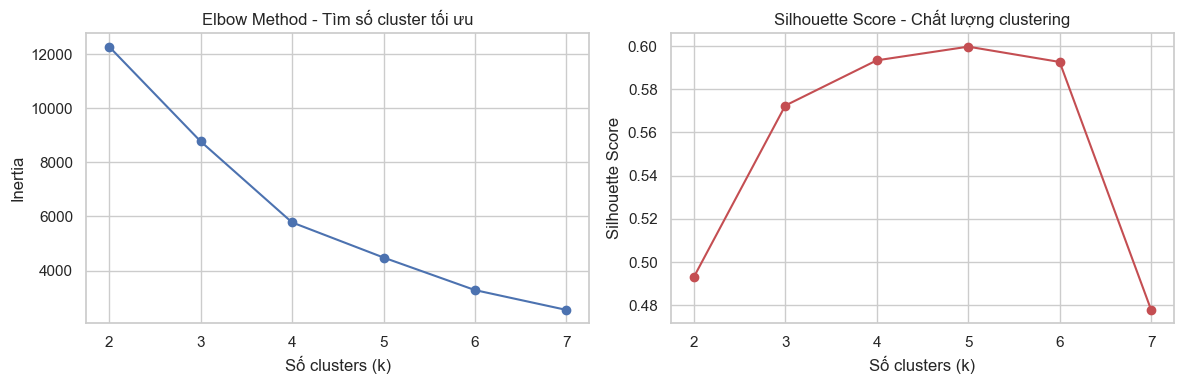

=== PHÂN TÍCH CLUSTERING ===
Silhouette Score: 0.572

Cluster 0 (1578 jobs):
  - Lương trung bình: 2237
  - Kinh nghiệm trung bình: 2.8 năm
  - Top 3 Job phổ biến: {'Data Analyst': 89, 'Data Engineer': 88, 'Senior Data Analyst': 42}

Cluster 1 (1180 jobs):
  - Lương trung bình: 2173
  - Kinh nghiệm trung bình: 2.8 năm
  - Top 3 Job phổ biến: {'Data Engineer': 162, 'Data Analyst': 123, 'Data Scientist': 61}

Cluster 2 (196 jobs):
  - Lương trung bình: 3167
  - Kinh nghiệm trung bình: 3.7 năm
  - Top 3 Job phổ biến: {'Data Engineer': 47, 'Senior Data Engineer': 13, 'Data Analyst': 11}


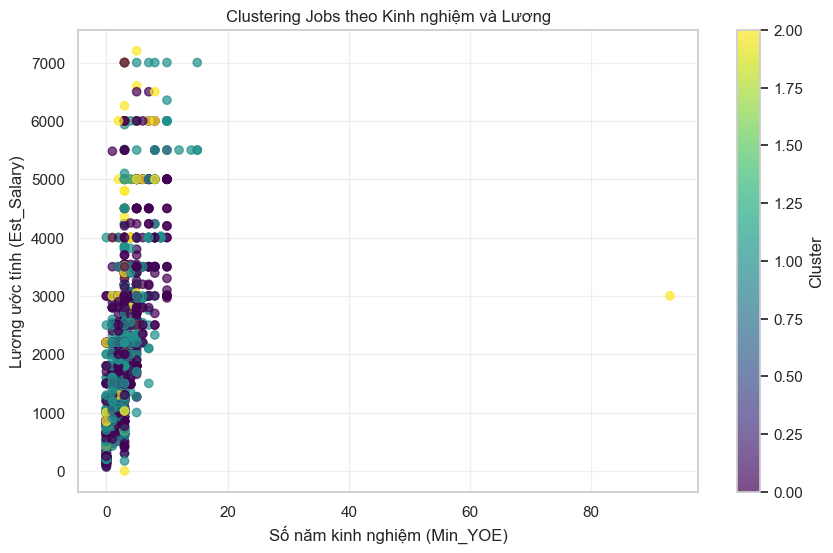

In [12]:
# 7. PHÂN TÍCH CLUSTERING (K-means) - Nhóm các job theo đặc điểm
# Phân nhóm công việc theo lương và kinh nghiệm bằng k -means clustering
# Xác định số nhóm tối ưu bằng Elbow method và silhouette score
# phân tích đặc điểm từng nhóm 
# trực quan hóa kết quả bằng biểu đồ scatter plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load dữ liệu
CLEAN_PATH = r"D:\Truc_quan\Data_Jobs_Clean.csv"
df = pd.read_csv(CLEAN_PATH, encoding="utf-8")

# Chuẩn bị dữ liệu cho clustering
cluster_features = ['Min_YOE', 'Est_Salary']
if 'Location' in df.columns:
    # Chuyển Location thành số
    location_encoded = pd.get_dummies(df['Location'], prefix='Location')
    cluster_data = pd.concat([df[cluster_features], location_encoded], axis=1)
else:
    cluster_data = df[cluster_features]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Tìm số cluster tối ưu (Elbow method)
# Elbow_method là kỹ thuật dùng để xác định số cụm (k) tối ưu trong K-means clustering
# vẽ đồ Elbow plot và silhouette score để chọn k
inertias = []
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_data_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(cluster_data_scaled, kmeans.labels_))

# Vẽ Elbow plot và Silhouette score
# silhouette score là thước đo chất lượng của clustering, giá trị từ -1 đến 1 
# nó giúp đánh giá mức độ phù hợp của các điểm dữ liệu trong cụm
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Số clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method - Tìm số cluster tối ưu')
ax1.grid(True)

ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Số clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score - Chất lượng clustering')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Chọn k=3 (dựa trên silhouette score)
optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) 
cluster_labels = kmeans_final.fit_predict(cluster_data_scaled)

# Thêm cluster labels vào dataframe
df['Cluster'] = cluster_labels

# Phân tích các cluster
print("=== PHÂN TÍCH CLUSTERING ===")
print(f"Silhouette Score: {silhouette_score(cluster_data_scaled, cluster_labels):.3f}")

# Vòng lặp dùng để in đặc điểm từng cluster
for i in range(optimal_k):
    cluster_data_i = df[df['Cluster'] == i]
    print(f"\nCluster {i} ({len(cluster_data_i)} jobs):")
    print(f"  - Lương trung bình: {cluster_data_i['Est_Salary'].mean():.0f}")
    print(f"  - Kinh nghiệm trung bình: {cluster_data_i['Min_YOE'].mean():.1f} năm")
    print(f"  - Top 3 Job phổ biến: {cluster_data_i['Job_Title'].value_counts().head(3).to_dict()}")

# Trực quan hóa clustering
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Min_YOE'], df['Est_Salary'], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Số năm kinh nghiệm (Min_YOE)')
plt.ylabel('Lương ước tính (Est_Salary)')
plt.title('Clustering Jobs theo Kinh nghiệm và Lương')
plt.grid(True, alpha=0.3)
plt.show()


=== PHÂN TÍCH TƯƠNG QUAN GIỮA CÁC BIẾN ===


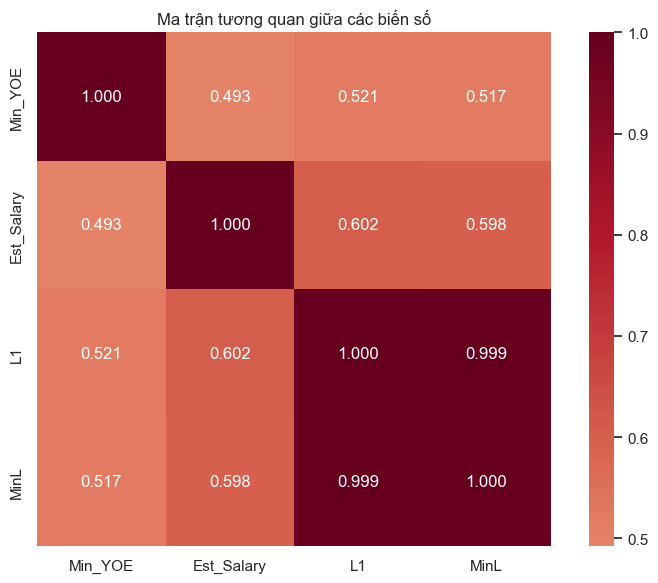


Tương quan với Est_Salary:
  L1: 0.602
  MinL: 0.598
  Min_YOE: 0.493

=== TẦM QUAN TRỌNG CỦA CÁC BIẾN ===
Tầm quan trọng của các biến:
               Biến  Tầm quan trọng
0           Min_YOE        0.912228
3   Location_REMOTE        0.062166
2     Location_HCMC        0.009630
1    Location_HANOI        0.008483
4  Location_VIETNAM        0.007493


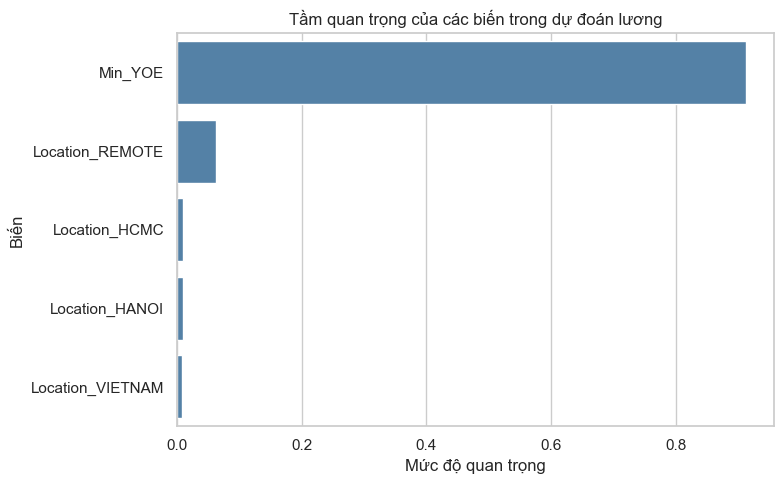


=== KẾT LUẬN ===
1. Biến có tương quan mạnh nhất với lương: L1
2. Biến quan trọng nhất trong mô hình: Min_YOE
3. Mức tương quan: 0.602
4. Mức quan trọng: 0.912


In [13]:
# 8. PHÂN TÍCH TƯƠNG QUAN VÀ TẦM QUAN TRỌNG BIẾN
# Phân tích tương quan giữa các biến số
# Xác định tầm quan trọng của các biến trong dự đoán lương bằng heatmap và Random Forest
# Đồng thời rút ra kết luận về biến quan trọng nhất
# Sử dụng biểu đồ heatmap và Random Forest Regressor , barplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# Load dữ liệu
CLEAN_PATH = r"D:\Truc_quan\Data_Jobs_Clean.csv"
df = pd.read_csv(CLEAN_PATH, encoding="utf-8")

print("=== PHÂN TÍCH TƯƠNG QUAN GIỮA CÁC BIẾN ===")

# 1. Correlation Matrix đơn giản
numeric_cols = ['Min_YOE', 'Est_Salary', 'L1', 'MinL']
correlation_matrix = df[numeric_cols].corr()

# Heatmap correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            fmt='.3f')
plt.title('Ma trận tương quan giữa các biến số')
plt.tight_layout()
plt.show()

# Phân tích tương quan với lương
print("\nTương quan với Est_Salary:")
salary_corr = correlation_matrix['Est_Salary'].drop('Est_Salary').sort_values(key=abs, ascending=False)
for var, corr in salary_corr.items():
    print(f"  {var}: {corr:.3f}")

# 2. Feature Importance đơn giản
print("\n=== TẦM QUAN TRỌNG CỦA CÁC BIẾN ===")

# Chuẩn bị dữ liệu
feature_cols = ['Min_YOE']
if 'Location' in df.columns:
    feature_cols.append('Location')

# One-hot encoding cho Location
X_simple = df[feature_cols].copy()
if 'Location' in X_simple.columns:
    X_encoded = pd.get_dummies(X_simple, columns=['Location'])
else:
    X_encoded = X_simple

y_simple = df['Est_Salary']

# Random Forest đơn giản
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_encoded, y_simple)

# Feature importance
feature_importance = pd.DataFrame({
    'Biến': X_encoded.columns,
    'Tầm quan trọng': rf_model.feature_importances_
}).sort_values('Tầm quan trọng', ascending=False)

print("Tầm quan trọng của các biến:")
print(feature_importance)

# Trực quan hóa
plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance, x='Tầm quan trọng', y='Biến', 
            color='steelblue')
plt.title('Tầm quan trọng của các biến trong dự đoán lương')
plt.xlabel('Mức độ quan trọng')
plt.tight_layout()
plt.show()

# 3. Kết luận đơn giản
print("\n=== KẾT LUẬN ===")
print("1. Biến có tương quan mạnh nhất với lương:", salary_corr.index[0])
print("2. Biến quan trọng nhất trong mô hình:", feature_importance.iloc[0]['Biến'])
print("3. Mức tương quan:", f"{salary_corr.iloc[0]:.3f}")
print("4. Mức quan trọng:", f"{feature_importance.iloc[0]['Tầm quan trọng']:.3f}")
